In [1]:
#Imports:
#General imports
import numpy as np
import pandas as pd



# Plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [70]:
#Imports:
#loading the model
import joblib

#hypothesis testing:
from scipy import stats


In [3]:
#Imports:
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#Other models
from xgboost import XGBClassifier


#Sklearn metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
def nan_vis(df):
    """
    Visualizes missing values in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    - str: A message indicating if there are any missing values or not.
    - If there are missing values, returns a bar graph with the missing values.
    """

    # Visualize missing values
    if df.isna().sum().sum() == 0:
        return "There are no missing values"
    else:
        plt.figure(figsize=(10, 6))
        plt.title("Missing Values")
        ax = sns.barplot(x=df.columns, y=df.isna().sum())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.xlabel("Columns")
        plt.ylabel("Missing Values Count")
        plt.show()

In [5]:
def replace_nan_with_zero(df, columns):
    """
    Replaces the NaN values with 0

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - List columns of the DataFrame that will be removed.

    Returns:
    - df (pandas.DataFrame): The input DataFrame with the updated values
    """
    df[columns] = df[columns].fillna(0)
    return df

In [6]:
#Loading the model
xg_model = joblib.load('../model/it2_xgboost.pkl')

In [7]:
xg_model.best_params_

{'model__colsample_bytree': 0.9,
 'model__gamma': 0.1,
 'model__learning_rate': 1,
 'model__max_depth': 5,
 'model__n_estimators': 200,
 'model__reg_alpha': 1,
 'model__reg_lambda': 0.5,
 'model__scale_pos_weight': 1}

In [8]:
df = pd.read_csv('../data/elenas-it2-postpreprocessing.csv')
df.drop(["seller_created_at"], axis=1, inplace=True)

In [9]:
df["churn"].value_counts()

1    38760
0     8944
Name: churn, dtype: int64

In [10]:
#Splitting the variables
X = df.drop(columns="churn")
y = df["churn"]

#Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

In [11]:
# Predict labels
y_pred = xg_model.predict(X_test)
recall = recall_score(y_test, y_pred).round(3)
#Sanity check: 
print(f"""
- Accuracy: {xg_model.score(X_test, y_test).round(3)}
- Recall: {recall}
- In the real life, that recall, would be equivalent to failing in classifying {(((df["churn"]==1).count())*(1-recall)).round(0)} sellers as churn from a base of {df["seller_id"].count()} sellers
""")


- Accuracy: 0.941
- Recall: 0.973
- In the real life, that recall, would be equivalent to failing in classifying 1288.0 sellers as churn from a base of 47704 sellers



## Interpretation of a similar model:

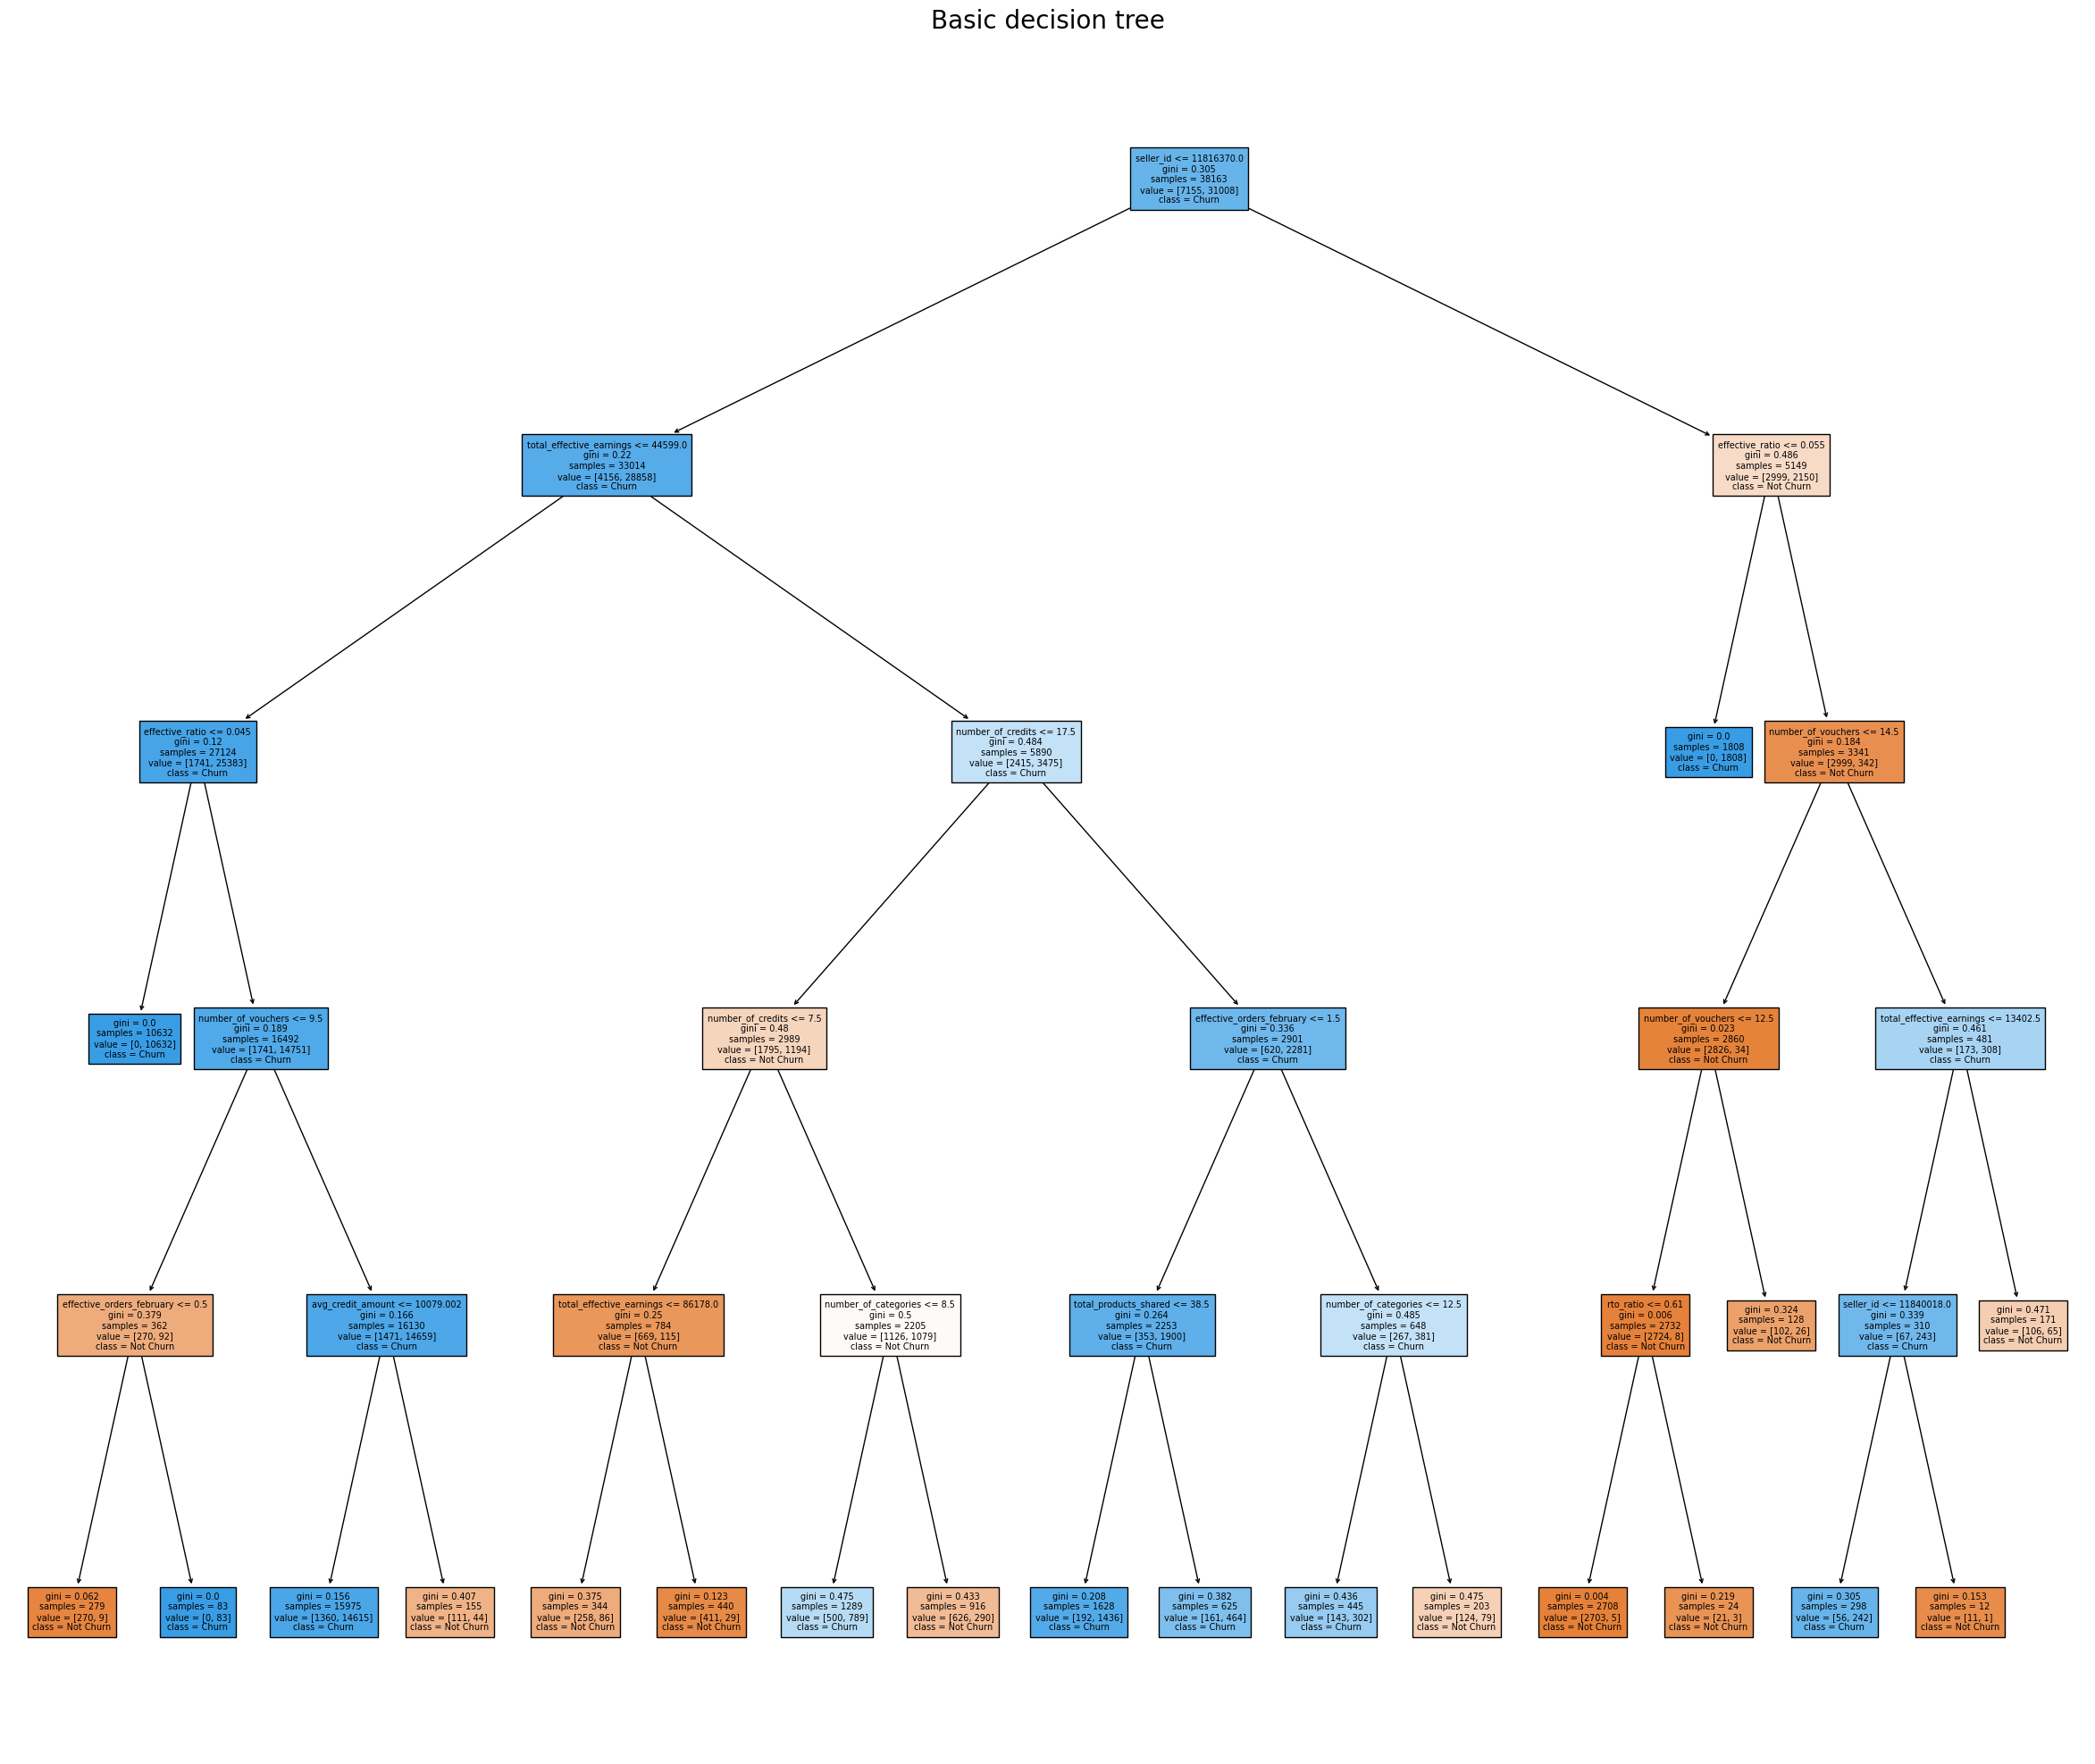

In [12]:
#Creating a decision tree
basic_model = DecisionTreeClassifier(max_depth=5, min_samples_split=200)
basic_model.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(30,25))
plot_tree(basic_model, feature_names=X_train.columns, filled=True, class_names=["Not Churn", "Churn"], impurity=True, fontsize=7)
plt.title("Basic decision tree", fontsize=20)
plt.show()

## Features

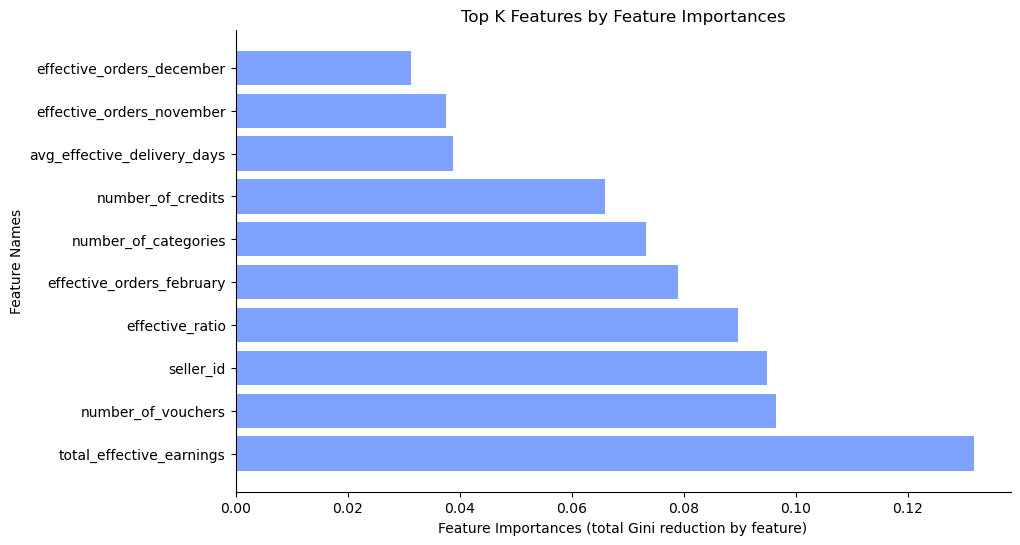

In [13]:
#Feature importance visualization
xgboost = xg_model.best_estimator_.named_steps['model']

# Retrieve the features with their respective n ames
feature_importances = xgboost.feature_importances_


feature_names = X_train.columns

# Sort the feature importances desc
indices = np.argsort(feature_importances)[::-1]

#Top K features
top_k_indices = indices[:10]  

# Feature names for the top K features
top_k_feature_names = feature_names[top_k_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_k_feature_names)), feature_importances[top_k_indices], align='center', color="#80a2ff")
plt.yticks(range(len(top_k_feature_names)), top_k_feature_names)
plt.xlabel('Feature Importances (total Gini reduction by feature)')
plt.ylabel('Feature Names')
plt.title('Top K Features by Feature Importances')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

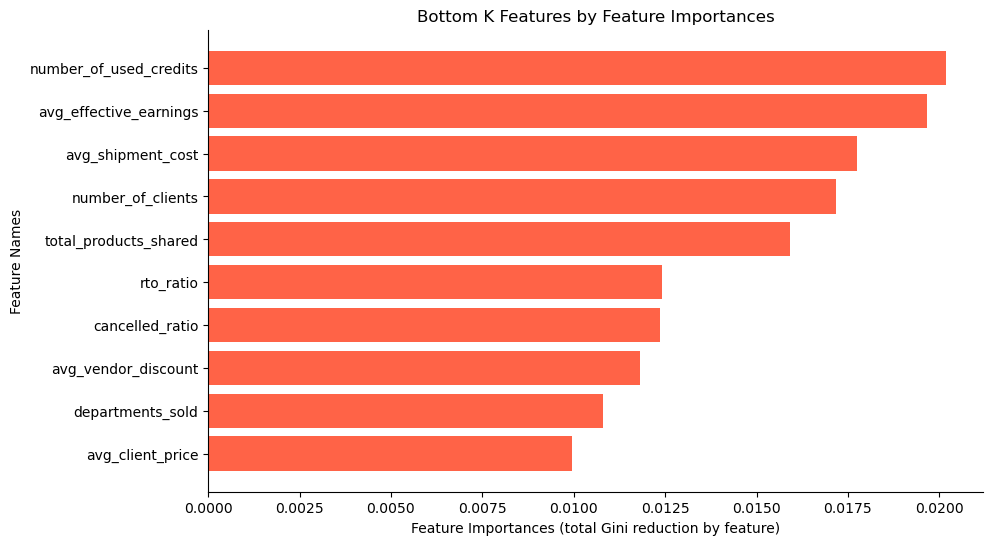

In [14]:
# Indices of the bottom K features
bottom_k_indices = feature_importances.argsort()[4:14]

# Feature names for the bottom K features
bottom_k_feature_names = feature_names[bottom_k_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(bottom_k_feature_names)), feature_importances[bottom_k_indices], align='center', color="tomato")
plt.yticks(range(len(bottom_k_feature_names)), bottom_k_feature_names)
plt.xlabel('Feature Importances (total Gini reduction by feature)')
plt.ylabel('Feature Names')
plt.title('Bottom K Features by Feature Importances')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()



## Evaluation of the misclassification

In [15]:
#Prediction:
predicted_labels = xg_model.predict(X_test)

#Comparing with the actual labels: Boolean of the missclassified samples
misclassified_indices = y_test != predicted_labels

#Obtaining the indices:Specific feature values
misclassified_samples = X_test[misclassified_indices]

#Obtaining corresponding the true labels
true_labels = y_test[misclassified_indices]



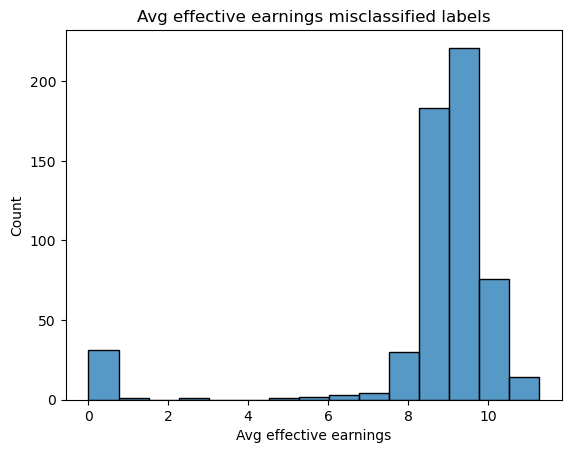

In [16]:

sns.histplot(data=misclassified_samples["avg_effective_earnings"], bins=15)
plt.xlabel("Avg effective earnings")
plt.title("Avg effective earnings misclassified labels")
plt.show()

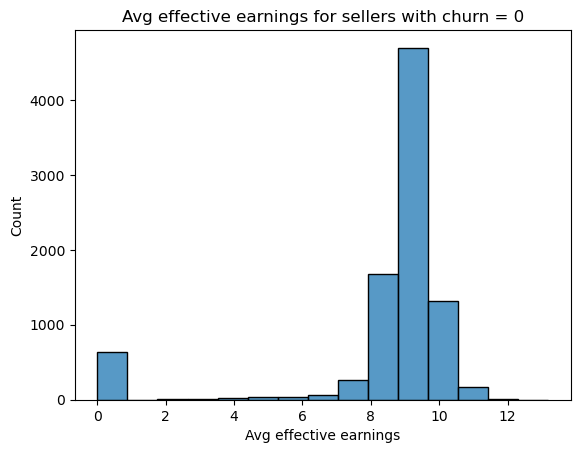

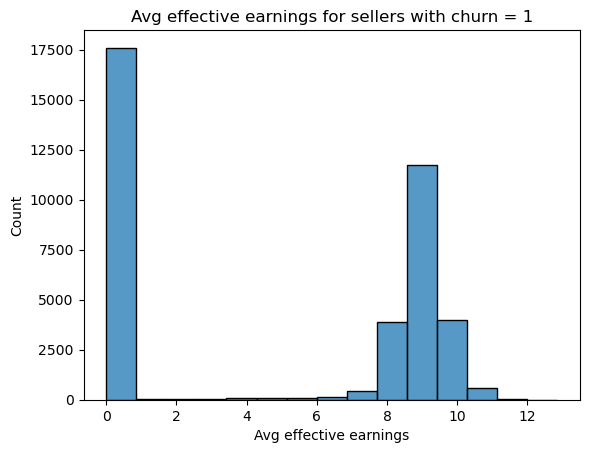

In [17]:
sns.histplot(data=df[df["churn"] == 0]["avg_effective_earnings"], bins=15)
plt.xlabel("Avg effective earnings")
plt.title("Avg effective earnings for sellers with churn = 0")
plt.show()

sns.histplot(data=df[df["churn"] == 1]["avg_effective_earnings"], bins=15)
plt.xlabel("Avg effective earnings")
plt.title("Avg effective earnings for sellers with churn = 1")
plt.show()




In [18]:
misclassified_samples["normal_avg_effective_earnings"] = np.expm1(misclassified_samples["avg_effective_earnings"])

misclassified_samples[["avg_effective_earnings", "normal_avg_effective_earnings"]]


/var/folders/27/tbf7s19s47137sfh7rlj9pvh0000gn/T/ipykernel_35070/3300350080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_samples["normal_avg_effective_earnings"] = np.expm1(misclassified_samples["avg_effective_earnings"])


avg_effective_earnings  normal_avg_effective_earnings
6993                10.499751                   36305.466667
12864                8.611906                    5495.714286
20617                9.293921                   10870.727273
25119                8.753572                    6332.272727
41354                8.967122                    7840.000000
...                       ...                            ...
13481                8.841923                    6917.285714
10542               10.242100                   28059.000000
34128                9.036106                    8400.000000
33119                8.984694                    7979.000000
22540                9.676739                   15941.416667

[567 rows x 2 columns]

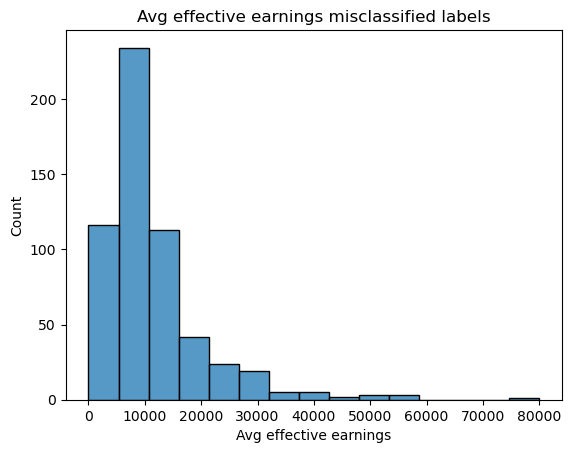

In [19]:

sns.histplot(data=misclassified_samples["normal_avg_effective_earnings"], bins=15)
plt.xlabel("Avg effective earnings")
plt.title("Avg effective earnings misclassified labels")
plt.show()

In [20]:
"""plot misclassified on pca:
 - depending if it is on PCA, revisar 2 veecs
 - scatter con misclassified duplicar
 - hacer hypothesis test cuando encuentre una rara
 """

'plot misclassified on pca:\n - depending if it is on PCA, revisar 2 veecs\n - scatter con misclassified duplicar\n - hacer hypothesis test cuando encuentre una rara\n '

In [21]:


fig = px.box(df, x="churn", y="avg_effective_earnings", points="all")
fig.show()

In [22]:
df["avg_effective_earnings"].max()

13.188557402438803

In [23]:
fig = px.box(df, x="churn", y="number_of_vouchers", points="all")
fig.show()


In [24]:
fig = px.box(misclassified_samples, y="number_of_vouchers", points="all")
fig.show()

**Confidence on the probabilities**

In [25]:
predicted_probabilities = xg_model.predict_proba(X_test)
misclassified_probabilities = predicted_probabilities[misclassified_indices]


In [26]:
misclassified_probabilities

array([[0.42705917, 0.5729408 ],
       [0.5026771 , 0.49732292],
       [0.77844   , 0.22156   ],
       ...,
       [0.96554893, 0.03445108],
       [0.35112268, 0.6488773 ],
       [0.950712  , 0.04928796]], dtype=float32)

In [27]:
# Create a DataFrame with misclassified samples and their probabilities
misclassified_data = pd.DataFrame(misclassified_samples, columns=df.columns)  # Assuming df is the original DataFrame
misclassified_data["misclassified_probability"] = np.max(misclassified_probabilities, axis=1)  # Assuming binary classification

# Review the misclassified data and probabilities
misclassified_data

seller_id  effective_ratio  rto_ratio  cancelled_ratio  \
6993    11487842             0.37       0.05             0.56   
12864   11539132             0.50       0.21             0.21   
20617   11616970             0.61       0.17             0.22   
25119   11665991             0.61       0.28             0.06   
41354   11817435             0.50       0.50             0.00   
...          ...              ...        ...              ...   
13481   11544395             1.00       0.00             0.00   
10542   11519805             0.83       0.08             0.08   
34128   11745481             0.25       0.50             0.25   
33119   11736469             1.00       0.00             0.00   
22540   11638219             0.44       0.15             0.15   

       departments_sold  number_of_clients  avg_effective_delivery_days  \
6993                  3                 15                     2.495682   
12864                 1                  9                     1.945910   
20617                 2                 14                     1.919859   
25119                 1                 14                     1.835776   
41354                 1                  2                     0.693147   
...                 ...                ...                          ...   
13481                 1                  3                     1.742219   
10542                 2                  8                     2.219203   
34128                 1                  2                     1.098612   
33119                 2                  4                     2.197225   
22540                 5                 15                     1.921325   

       total_effective_earnings  avg_effective_earnings  avg_client_price  \
6993                   544582.0               10.499751     144875.609756   
12864                   38470.0                8.611906      47671.285714   
20617                  119578.0                9.293921     114516.666667   
25119                   69655.0                8.753572      54538.888889   
41354                    7840.0                8.967122      58700.000000   
...                         ...                     ...               ...   
13481                   48421.0                8.841923      48271.428571   
10542                  280590.0               10.242100     230075.000000   
34128                    8400.0                9.036106      47900.000000   
33119                   39895.0                8.984694      55600.000000   
22540                  191297.0                9.676739      90112.740741   

       ...  number_of_categories  average_prod_existence_days  \
6993   ...                    16                        378.0   
12864  ...                     6                        554.0   
20617  ...                    12                        469.0   
25119  ...                    10                        417.0   
41354  ...                     1                        548.0   
...    ...                   ...                          ...   
13481  ...                     6                        478.0   
10542  ...                     6                        530.0   
34128  ...                     2                        505.0   
33119  ...                     4                        319.0   
22540  ...                     8                        413.0   

       total_products_shared  number_of_vouchers  number_of_credits  \
6993                     199                  81                 18   
12864                      8                  41                 11   
20617                     64                  57                  7   
25119                     46                  59                 11   
41354                     27                  15                  6   
...                      ...                 ...                ...   
13481                     49                  50                 29   
10542                     28                  92   

Revisar days since seller creation para los 3

avg credit amount

In [28]:
fig = px.box(df, x="churn", y="avg_credit_amount", points="all")
fig.show()

In [29]:
#Tagging the misclassified
misclassified_data["is_misclassified"] = 1
misclassified_data.head(10)

seller_id  effective_ratio  rto_ratio  cancelled_ratio  \
6993    11487842             0.37       0.05             0.56   
12864   11539132             0.50       0.21             0.21   
20617   11616970             0.61       0.17             0.22   
25119   11665991             0.61       0.28             0.06   
41354   11817435             0.50       0.50             0.00   
476     11420810             0.69       0.15             0.15   
18167   11591620             0.60       0.40             0.00   
28845   11701836             0.67       0.17             0.17   
15562   11563473             0.68       0.09             0.18   
36747   11769057             0.67       0.00             0.22   

       departments_sold  number_of_clients  avg_effective_delivery_days  \
6993                  3                 15                     2.495682   
12864                 1                  9                     1.945910   
20617                 2                 14                     1.919859   
25119                 1                 14                     1.835776   
41354                 1                  2                     0.693147   
476                   1                  6                     1.791759   
18167                 1                  1                     1.202972   
28845                 3                  4                     2.047693   
15562                 2                 10                     1.526056   
36747                 4                  6                     1.465568   

       total_effective_earnings  avg_effective_earnings  avg_client_price  \
6993                   544582.0               10.499751     144875.609756   
12864                   38470.0                8.611906      47671.285714   
20617                  119578.0                9.293921     114516.666667   
25119                   69655.0                8.753572      54538.888889   
41354                    7840.0                8.967122      58700.000000   
476                    116502.0                9.468516      99976.923077   
18167                    7800.0                7.170888      51926.300000   
28845                   78195.0                9.880718     356016.666667   
15562                  100491.0                8.809923      43359.090909   
36747                  106593.0                9.785070      73055.555556   

       ...  average_prod_existence_days  total_products_shared  \
6993   ...                        378.0                    199   
12864  ...                        554.0                      8   
20617  ...                        469.0                     64   
25119  ...                        417.0                     46   
41354  ...                        548.0                     27   
476    ...                        375.0                     59   
18167  ...                        367.0                      1   
28845  ...                        430.0                     90   
15562  ...                        382.0                     54   
36747  ...                        470.0                     75   

       number_of_vouchers  number_of_credits  number_of_used_credits  \
6993                   81                 18                       3   
12864                  41                 11                       0   
20617                  57                  7                       0   
25119                  59                 11                       0   
41354                  15                  6                       0   
476                    41                 18                       0   
18167                  23                 13                       0   
28845                  28                 18                       0   
15562                  44                 28                       0   
36747                  25                 12                       0   

       avg_credit_amount  seller_creation_month  days_since_seller_creation  \
6993         8388.

In [30]:
#Joining the DFs:
misclassified_summary = misclassified_data[["seller_id", "misclassified_probability", "is_misclassified"]]

evaluation_df = pd.merge(X_test, misclassified_summary, how="left", on="seller_id")


In [31]:
evaluation_df.head(5)

seller_id  effective_ratio  rto_ratio  cancelled_ratio  departments_sold  \
0   11419049             0.83       0.17             0.00                 1   
1   11653024             0.70       0.10             0.10                 3   
2   11875266             0.00       0.50             0.50                 1   
3   11781345             0.50       0.50             0.00                 1   
4   11487842             0.37       0.05             0.56                 3   

   number_of_clients  avg_effective_delivery_days  total_effective_earnings  \
0                  3                     1.916923                   57043.0   
1                  9                     1.742219                   98281.0   
2                  1                     1.945910                       0.0   
3                  1                     1.609438                   10945.0   
4                 15                     2.495682                  544582.0   

   avg_effective_earnings  avg_client_price  ...  average_prod_existence_days  \
0                8.649151      42608.333333  ...                        394.0   
1                9.549747     102400.000000  ...                        695.0   
2                0.000000     281050.000000  ...                        746.0   
3                8.607674      43550.000000  ...                        814.0   
4               10.499751     144875.609756  ...                        378.0   

   total_products_shared  number_of_vouchers  number_of_credits  \
0                      2                  78                 26   
1                     59                  35                 15   
2                      0                   2                  2   
3                      5                  19                  9   
4                    199                  81                 18   

   number_of_used_credits  avg_credit_amount  seller_creation_month  \
0                       0        6346.153846                     10   
1                       0        4900.000000                      1   
2                       1        5000.000000                      4   
3                       0        6888.888889                      2   
4                       3        8388.888889                     10   

   days_since_seller_creation  misclassified_probability  is_misclassified  
0                         211                        NaN               NaN  
1                         114                        NaN               NaN  
2                          11                        NaN               NaN  
3                          63                        NaN               NaN  
4                         184                   0.572941               1.0  

[5 rows x 30 columns]

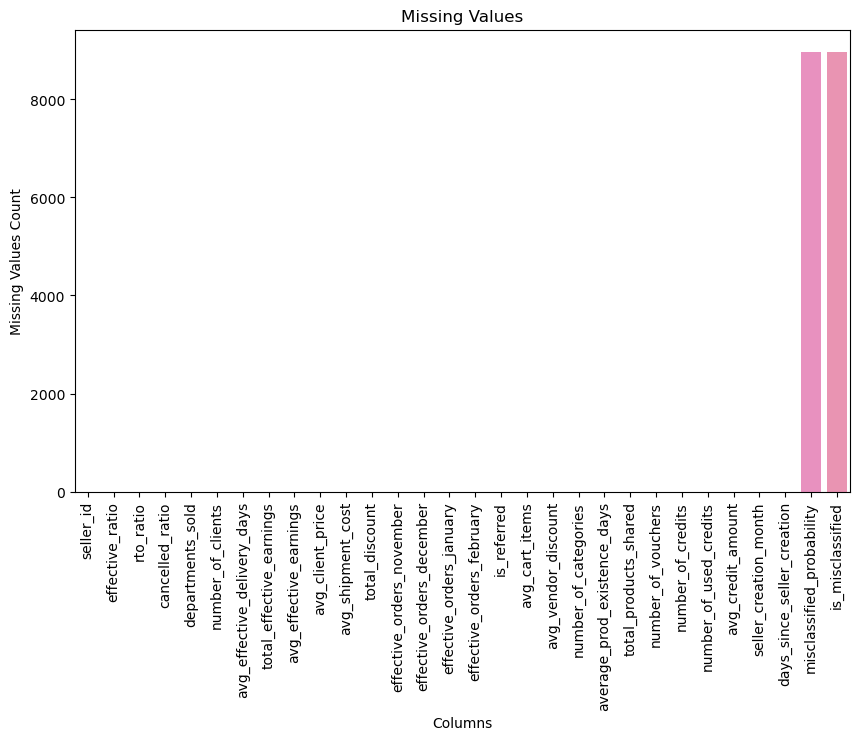

In [32]:
nan_vis(evaluation_df)

In [33]:
evaluation_df

seller_id  effective_ratio  rto_ratio  cancelled_ratio  \
0      11419049             0.83       0.17             0.00   
1      11653024             0.70       0.10             0.10   
2      11875266             0.00       0.50             0.50   
3      11781345             0.50       0.50             0.00   
4      11487842             0.37       0.05             0.56   
...         ...              ...        ...              ...   
9536   11447583             1.00       0.00             0.00   
9537   11682825             1.00       0.00             0.00   
9538   11525485             0.00       1.00             0.00   
9539   11757808             0.50       0.50             0.00   
9540   11419240             1.00       0.00             0.00   

      departments_sold  number_of_clients  avg_effective_delivery_days  \
0                    1                  3                     1.916923   
1                    3                  9                     1.742219   
2                    1                  1                     1.945910   
3                    1                  1                     1.609438   
4                    3                 15                     2.495682   
...                ...                ...                          ...   
9536                 1                  1                     1.098612   
9537                 1                  2                     1.504077   
9538                 1                  1                     1.945910   
9539                 1                  4                     2.079442   
9540                 1                  1                     1.098612   

      total_effective_earnings  avg_effective_earnings  avg_client_price  ...  \
0                      57043.0                8.649151      42608.333333  ...   
1                      98281.0                9.549747     102400.000000  ...   
2                          0.0                0.000000     281050.000000  ...   
3                      10945.0                8.607674      43550.000000  ...   
4                     544582.0               10.499751     144875.609756  ...   
...                        ...                     ...               ...  ...   
9536                   23750.0               10.075380     110600.000000  ...   
9537                   25221.0                9.442364     154050.000000  ...   
9538                       0.0                0.000000      38200.000000  ...   
9539                   18375.0                8.720297      33323.333333  ...   
9540                    8001.0                8.987447      45000.000000  ...   

      average_prod_existence_days  total_products_shared  number_of_vouchers  \
0                           394.0                      2                  78   
1                           695.0                     59                  35   
2                           746.0                      0                   2   
3                           814.0                      5                  19   
4                           378.0                    199                  81   
...                           ...                    ...                 ...   
9536                        240.0                      1                  55   
9537                        412.0                      0                  12   
9538                        354.0                      0                  16   
9539                        582.0                     27                  16   
9540                        859.0                      0                  63   

      number_of_credits  number_of_used_credits  avg_credit_amount  \
0                    26                       0        6346.153846   
1                    15                       0        4900.000000   
2                     2                       1        5000.000000   
3                     9                       0        6888.888889   
4                    18                       3        8388.8888

In [34]:
replace_nan_with_zero(evaluation_df, ["misclassified_probability", "is_misclassified"])

seller_id  effective_ratio  rto_ratio  cancelled_ratio  \
0      11419049             0.83       0.17             0.00   
1      11653024             0.70       0.10             0.10   
2      11875266             0.00       0.50             0.50   
3      11781345             0.50       0.50             0.00   
4      11487842             0.37       0.05             0.56   
...         ...              ...        ...              ...   
9536   11447583             1.00       0.00             0.00   
9537   11682825             1.00       0.00             0.00   
9538   11525485             0.00       1.00             0.00   
9539   11757808             0.50       0.50             0.00   
9540   11419240             1.00       0.00             0.00   

      departments_sold  number_of_clients  avg_effective_delivery_days  \
0                    1                  3                     1.916923   
1                    3                  9                     1.742219   
2                    1                  1                     1.945910   
3                    1                  1                     1.609438   
4                    3                 15                     2.495682   
...                ...                ...                          ...   
9536                 1                  1                     1.098612   
9537                 1                  2                     1.504077   
9538                 1                  1                     1.945910   
9539                 1                  4                     2.079442   
9540                 1                  1                     1.098612   

      total_effective_earnings  avg_effective_earnings  avg_client_price  ...  \
0                      57043.0                8.649151      42608.333333  ...   
1                      98281.0                9.549747     102400.000000  ...   
2                          0.0                0.000000     281050.000000  ...   
3                      10945.0                8.607674      43550.000000  ...   
4                     544582.0               10.499751     144875.609756  ...   
...                        ...                     ...               ...  ...   
9536                   23750.0               10.075380     110600.000000  ...   
9537                   25221.0                9.442364     154050.000000  ...   
9538                       0.0                0.000000      38200.000000  ...   
9539                   18375.0                8.720297      33323.333333  ...   
9540                    8001.0                8.987447      45000.000000  ...   

      average_prod_existence_days  total_products_shared  number_of_vouchers  \
0                           394.0                      2                  78   
1                           695.0                     59                  35   
2                           746.0                      0                   2   
3                           814.0                      5                  19   
4                           378.0                    199                  81   
...                           ...                    ...                 ...   
9536                        240.0                      1                  55   
9537                        412.0                      0                  12   
9538                        354.0                      0                  16   
9539                        582.0                     27                  16   
9540                        859.0                      0                  63   

      number_of_credits  number_of_used_credits  avg_credit_amount  \
0                    26                       0        6346.153846   
1                    15                       0        4900.000000   
2                     2                       1        5000.000000   
3                     9                       0        6888.888889   
4                    18                       3        8388.8888

In [35]:
(evaluation_df["is_misclassified"].sum()/ evaluation_df["is_misclassified"].count())* 100

5.9427732942039615

Scale before and not apply PCA to evaluation_df, X_test

In [37]:
# Perform Standard Scaling
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

In [38]:
PCA_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])

In [48]:
evaluation_df["is_misclassified"] = evaluation_df["is_misclassified"].astype(str)

In [65]:

fig = px.scatter( x=PCA_df["PC1"], y=PCA_df["PC2"], color=evaluation_df["is_misclassified"], symbol=y_test)
fig.show()

In [74]:

fig = px.scatter( x=PCA_df["PC1"], y=PCA_df["PC2"], color=y_test, symbol=y_test)
fig.show()

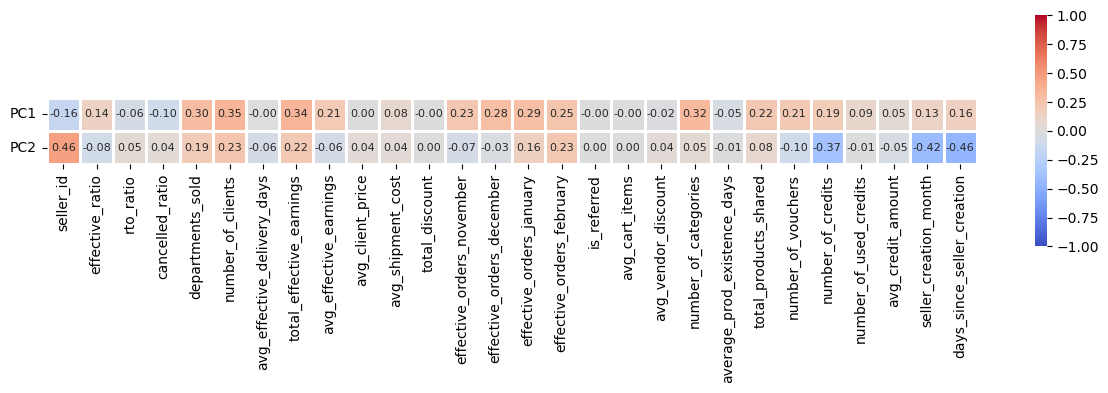

In [59]:
# Evaluation of PC
plt.figure(figsize=(15, 3))

# PC heatmap
ax = sns.heatmap(pca.components_,
                 cmap='coolwarm',
                 yticklabels=["PC" + str(x) for x in range(1, pca.n_components_ + 1)],
                 xticklabels=list(X_test.columns),
                 linewidths=1,
                 annot=True,
                 annot_kws={"size": 8},  # Increase font size for annotations
                 fmt=".2f",  # Display annotations with 2 decimal places
                 vmin=-1,
                 vmax=1,
                 cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.set_aspect("equal")

In [60]:
#Evaluating the range of PC1 -1.05 to 0.08

evaluation_df = pd.concat([evaluation_df, PCA_df], axis=1)

In [67]:
PC1_lower_range = -1.05
PC1_upper_range = 0.08

#Sanity check
evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range)]


seller_id  effective_ratio  rto_ratio  cancelled_ratio  \
3      11781345             0.50       0.50             0.00   
8      11848145             0.69       0.15             0.15   
13     11545789             0.33       0.00             0.00   
16     11803107             0.88       0.00             0.12   
17     11436215             0.00       0.50             0.50   
...         ...              ...        ...              ...   
9532   11417363             0.00       0.50             0.50   
9533   11803418             0.50       0.50             0.00   
9537   11682825             1.00       0.00             0.00   
9538   11525485             0.00       1.00             0.00   
9539   11757808             0.50       0.50             0.00   

      departments_sold  number_of_clients  avg_effective_delivery_days  \
3                    1                  1                     1.609438   
8                    1                  9                     1.631199   
13                   1                  2                     2.197225   
16                   1                  7                     1.098612   
17                   1                  1                     1.945910   
...                ...                ...                          ...   
9532                 1                  1                     1.945910   
9533                 1                  3                     0.916291   
9537                 1                  2                     1.504077   
9538                 1                  1                     1.945910   
9539                 1                  4                     2.079442   

      total_effective_earnings  avg_effective_earnings  avg_client_price  ...  \
3                      10945.0                8.607674      43550.000000  ...   
8                     162640.0                9.802125      80723.076923  ...   
13                         0.0                0.000000      91231.333333  ...   
16                    111786.0                9.678494     204337.500000  ...   
17                         0.0                0.000000      95950.000000  ...   
...                        ...                     ...               ...  ...   
9532                       0.0                0.000000     150500.000000  ...   
9533                   12316.0                8.725670      35850.000000  ...   
9537                   25221.0                9.442364     154050.000000  ...   
9538                       0.0                0.000000      38200.000000  ...   
9539                   18375.0                8.720297      33323.333333  ...   

      number_of_vouchers  number_of_credits  number_of_used_credits  \
3                     19                  9                       0   
8                      5                  4                       0   
13                    39                 25                       0   
16                    16                 11                       1   
17                    14                  6                       0   
...                  ...                ...                     ...   
9532                  15                  2                       0   
9533                  17                 12                       0   
9537                  12                 10                       0   
9538                  16                  7                       0   
9539                  16                  6                       0   

      avg_credit_amount  seller_creation_month  days_since_seller_creation  \
3           6888.888889                      2                          63   
8          10625.000000                      4                          28   
13          6200.000000                     11                         156   
16          7181.818182                      3                          53   
17          6333.333333                     10                         204   
...                 ...                    ...        

## Hypothesis testing:
1. Effective ratio
    Null hypothesis: there is no difference between the total effective earnings of the two groups
2. Total effective earnings
3. Number of credits

In [72]:
#1. Effective ratio:
group1_earnings = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] ==1)]["effective_ratio"]
group2_earnings = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] ==0)]["effective_ratio"]

# Two-sample t-test
t_statistic, p_value = stats.ttest_ind(group1_earnings, group2_earnings)

# Results
print("T-statistic:", t_statistic)
print("P-value:", p_value)


T-statistic: nan
P-value: nan


In [73]:
#1. Total effective earnings:
group1_earnings = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] ==1)]["effective_ratio"]
group2_earnings = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] ==0)]["effective_ratio"]

# Two-sample t-test
t_statistic, p_value = stats.ttest_ind(group1_earnings, group2_earnings)

# Results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

NameError: name 'scaled_group1_earnings' is not defined